<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%92%D1%8B%D1%80%D0%B0%D0%B2%D0%BD%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B8_%D1%80%D0%B5%D0%B3%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выравнивание и регистрация изображений с помощью OpenCV

# Aligning and registering images with OpenCV

В этом уроке вы узнаете, как выполнить выравнивание и регистрацию изображений с помощью OpenCV. Выравнивание и регистрация реализуется с помощью детекторов ключевых точек, локальных инвариантных дескрипторов и сопоставления ключевых точек.



In this tutorial, you will learn how to align and register images using OpenCV. Alignment and registration is implemented using cue point detectors, local invariant descriptors, and cue point matching.



Выравнивание и регистрация изображений - это:

Aligning and registering images is:

* Принятие двух входных изображений, содержащих один и тот же объект, но под немного разными углами обзора. Taking two input images containing the same object, but from slightly different viewing angles.
* Автоматическое вычисление матрицы гомографии, используемой для выравнивания изображений. Automatic calculation of the homography matrix used to align images.

Мы будем реализовывать выравнивание и регистрацию изображений, используя методы, основанные на выделении признаков.

We will implement image alignment and registration using feature extraction techniques.





Методы, основанные на выделении признаков, начинаются с обнаружения ключевых точек в наших двух входных изображениях:


Feature extraction techniques start by finding key points in our two input images:

* Ключевые точки предназначены для идентификации заметных областей входного изображения.  Cue points are for identifying prominent areas of the input image.

* Для каждой ключевой точки мы извлекаем локальные инвариантные дескрипторы, которые количественно определяют область, окружающую каждую ключевую точку во входном изображении. For each cue point, we extract local invariant descriptors that quantify the area surrounding each cue point in the input image.





Мы применяем такие алгоритмы, как RANSAC, для сопоставления наших ключевых точек и определения их соответствия:
При условии, что у нас достаточно совпадений и соответствий по ключевым точкам, мы можем затем вычислить матрицу гомографии , которая позволяет нам применить перспективную деформацию для выравнивания изображений.


We use algorithms like RANSAC to match our keypoints and determine if they match:
Assuming we have enough key point matches and matches, we can then compute a homography matrix that allows us to apply perspective warp to align the images.





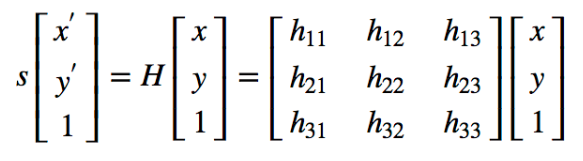

Рисунок 1. - Матрица гомографии 

Figure 1. - Homography matrix

### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_16.image_alignment_registration.zip
!unzip -qq Lesson_16.image_alignment_registration.zip
%cd /content/Lesson_16.image_alignment_registration/

--2022-02-10 07:05:33--  http://dataudt.ru/datasets/cv/Lesson_16.image_alignment_registration.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5260421 (5.0M) [application/zip]
Saving to: ‘Lesson_16.image_alignment_registration.zip’

Lesson_16.image_ali 100%[===================>]   5.02M  5.08MB/s    in 1.0s    

2022-02-10 07:05:35 (5.08 MB/s) - ‘Lesson_16.image_alignment_registration.zip’ saved [5260421/5260421]

/content/Lesson_16.image_alignment_registration


### Импорт библиотек
### Import Packages

In [2]:
# импортируем необходимые библиотеки
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab
### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10,10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()


### Выравнивание изображений с помощью OpenCV и сопоставления ключевых точек
### Aligning images with OpenCV and keypoint matching

In [4]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
	debug=False):
    # преобразуем входное изображение и шаблон в оттенки серого
	# convert both the input image and template to grayscale
	imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # используем ORB для обнаружения ключевых точек и извлечения (двоичного) локальных
	# инвариантных признаков
    # use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    # сопоставляем признаки
	# match the features
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)

    # сортируем совпадения по расстоянию (чем меньше расстояние,
	# чем "более похожи" функции)
    # sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)

    # оставляем только лучшие совпадения
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]

    # проверяем, должны ли мы визуализировать совпадающие ключевые точки
	# check to see if we should visualize the matched keypoints
	if debug:
		matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
		# plt_imshow("Matched Keypoints", matchedVis)
		plt_imshow("Совпавшие ключевые точки", matchedVis)

    # выделяем память для ключевых точек (x, y-координаты) из
	# лучших совпадений - мы будем использовать эти координаты для вычисления наших
	# матриц гомографии
    # allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")

    # перебираем лучшие совпадения
	# loop over the top matches
	for (i, m) in enumerate(matches):
        # указываем, что две ключевые точки на соответствующих изображениях
		# сопоставлены друг другу
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt

    # вычисляем матрицу гомографии между двумя наборами сопоставленных точек
    # compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)

    # используем матрицу гомографии для выравнивания изображений
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))

    # возвращаем выровненное изображение
	# return the aligned image
	return aligned

### Реализация нашего кода выравнивания изображений с помощью OpenCV
### Implementing our OpenCV image alignment script

In [5]:


# явно укажем аргументы необходимые для работы
# template - путь к шаблону 
# image - путь к изображению 

# explicitly specify the arguments needed to work
# image - image path
# template - the path to the template 
args = {
	"template": "template.png",
	"image": "scans/scan_01.jpg"
}

[INFO] loading images...
[INFO] aligning images...


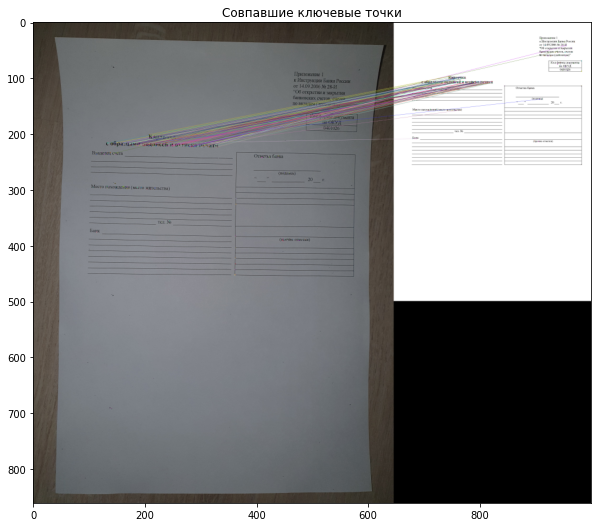

In [6]:
# загружаем входное изображение и шаблон с диска
# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(args["image"])
template = cv2.imread(args["template"])

# выравниваем изображения
# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template, debug=True)

In [7]:
# изменяем размер выровненного изображения и изображения шаблона, чтобы мы могли легко
# отобразить их на нашем экране
# resize both the aligned and template images so we can easily
# visualize them on our screen
aligned = imutils.resize(aligned, width=700)
template = imutils.resize(template, width=700)

# первая выходная визуализация выравнивания изображения будет
# параллельно сравниваться с выходным выровненным изображением и
# шаблоном
# our first output visualization of the image alignment will be a
# side-by-side comparison of the output aligned image and the
# template
stacked = np.hstack([aligned, template])

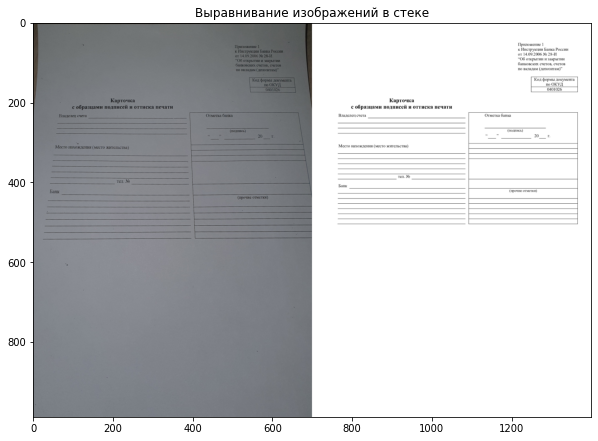

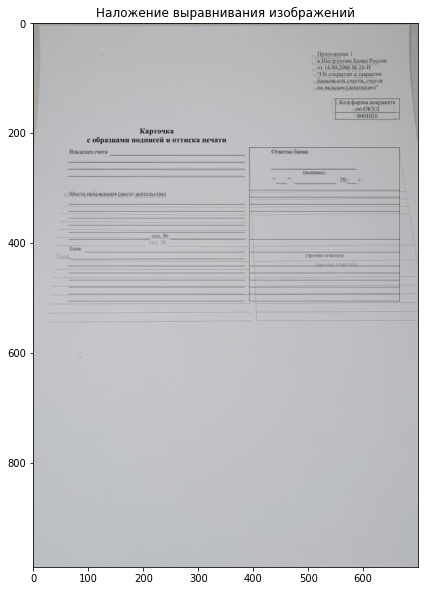

In [8]:
# вторая визуализация выравнивания изображений будет *перекрывать*
# выровненное изображение в шаблоне, чтобы мы могли получить представление о том,
# насколько хорошо у нас выравнивается изображение
# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# отображаем две визуализации выравнивания выходного изображения
# show the two output image alignment visualizations
plt_imshow("Выравнивание изображений в стеке", stacked)
plt_imshow("Наложение выравнивания изображений", output)
# plt_imshow("Image Alignment Stacked", stacked)
# plt_imshow("Image Alignment Overlay", output)